# Project Overview

Seiring meningkatnya jumlah pengguna internet dan volume informasi yang tersedia secara daring sejak akhir abad ke-20, pengguna kerap mengalami kesulitan dalam menemukan informasi yang benar-benar relevan. Dalam konteks hiburan digital seperti film, hal ini memunculkan kebutuhan akan sistem rekomendasi yang mampu membantu pengguna menemukan film sesuai preferensi mereka tanpa harus melakukan pencarian berulang. Rekomendasi film menjadi solusi yang populer untuk mempermudah proses pencarian dan pengambilan keputusan pengguna terhadap konten hiburan yang ingin mereka konsumsi Choi et al. (2012).

Menurut Choi et al. (2012), sistem rekomendasi sangat penting untuk mengurangi usaha pencarian informasi yang berulang dengan cara menyarankan konten yang relevan berdasarkan pola perilaku atau preferensi pengguna sebelumnya. Sistem ini secara signifikan dapat meningkatkan efisiensi dan pengalaman pengguna dalam menjelajahi konten digital, seperti film.

Lebih lanjut, Goyani & Chaurasiya (2020) menjelaskan bahwa sistem rekomendasi film dapat dikembangkan melalui dua pendekatan utama, yaitu *Collaborative Filtering*, yang merekomendasikan item berdasarkan kemiripan antar pengguna, dan *Content-Based Filtering*, yang memanfaatkan preferensi eksplisit dari pengguna untuk menyarankan konten serupa. Keduanya memiliki kelebihan masing-masing, dan penerapan gabungan dari kedua pendekatan ini dapat meningkatkan akurasi dan personalisasi rekomendasi.

Hal-hal tersebut mendorong saya untuk mengangkat topik ini dalam proyek yang akan saya kerjakan. Saya tertarik untuk membangun sistem rekomendasi film yang mengombinasikan metode *collaborative* dan *content-based filtering*, dengan tujuan untuk meningkatkan relevansi rekomendasi dan menciptakan pengalaman pengguna yang lebih personal. Selain itu, dunia hiburan adalah bidang yang sangat dinamis dan dekat dengan kehidupan sehari-hari, sehingga sistem seperti ini akan memiliki nilai guna praktis yang tinggi serta tantangan teknis yang menarik untuk dipecahkan.

**Referensi:**

- Choi, S. M., Ko, S. K., & Han, Y. S. (2012). A movie recommendation algorithm based on genre correlations. *Expert Systems with Applications, 39(9)*, 8079-8085.  
- Goyani, M., & Chaurasiya, N. (2020). A review of movie recommendation system: Limitations, Survey and Challenges. *ELCVIA. Electronic Letters on Computer Vision and Image Analysis, 19(3)*, 0018-37.

# Business Understanding

## Problem Statements

- Bagaimana cara membangun sistem rekomendasi yang dapat memberikan saran film atau acara TV yang relevan untuk pengguna berdasarkan konten dari film atau acara yang pernah mereka sukai sebelumnya?

- Dengan memanfaatkan informasi dari pengguna lain yang memiliki ketertarikan serupa, bagaimana sistem dapat merekomendasikan film atau acara TV yang mungkin disukai pengguna namun belum pernah ditonton sebelumnya?

## Goals

- Menghasilkan rekomendasi film atau acara TV yang dipersonalisasi untuk setiap pengguna menggunakan teknik Content-Based Filtering berdasarkan genre, deskripsi, dan skor film.

- Menghasilkan rekomendasi film atau acara TV dengan teknik Collaborative Filtering, dengan asumsi pengguna menyukai item yang disukai oleh pengguna lain yang serupa.

## Solution Approach

Untuk mencapai tujuan di atas, akan digunakan dua pendekatan utama dalam sistem rekomendasi:

- Content-Based Filtering:

  - Menggunakan informasi dari titles.csv seperti genres, description, dan tmdb_score untuk membangun profil konten dari tiap film.

  - Menghitung kemiripan antar judul (misalnya dengan TF-IDF + cosine similarity) untuk merekomendasikan film serupa dengan yang pernah disukai pengguna.

- Collaborative Filtering:

  - Karena tidak tersedia data eksplisit tentang rating dari pengguna, akan disimulasikan matriks user-item dengan cara tertentu (misalnya dengan implicit feedback dari popularitas, atau membuat skenario dummy).

  - Menggunakan pendekatan item-based collaborative filtering atau matrix factorization (SVD) untuk menemukan pola kesamaan antar pengguna atau antar judul.

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import ast

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Understanding

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle

In [6]:
!kaggle datasets download -d victorsoeiro/netflix-tv-shows-and-movies

Dataset URL: https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies
License(s): CC0-1.0


In [7]:
!unzip netflix-tv-shows-and-movies -d dataset

Archive:  netflix-tv-shows-and-movies.zip
  inflating: dataset/credits.csv     
  inflating: dataset/titles.csv      


#### Deskripsi Dataset

**1. `credits.csv` (5 kolom)**

Dataset ini berisi lebih dari 50.000 data kredit dari aktor dan sutradara yang terlibat dalam judul-judul Netflix. Terdiri dari 5 kolom informasi sebagai berikut:

- `person_id`: ID individu berdasarkan JustWatch.
- `id`: ID judul berdasarkan JustWatch.
- `name`: Nama aktor atau sutradara.
- `character_name`: Nama karakter (jika tersedia).
- `role` Peran sebagai ACTOR atau DIRECTOR.

**2. `titles.csv` (15 kolom)**

Dataset ini berisi lebih dari 5.000 judul unik yang tersedia di Netflix, dengan 15 kolom informasi sebagai berikut:

- `id`: ID judul berdasarkan JustWatch.
- `title`: Nama judul film atau acara.
- `show_type`: Tipe tayangan, bisa berupa MOVIE atau SHOW.
- `description`: Deskripsi singkat tentang judul.
- `release_year`: Tahun rilis.
- `age_certification`: Sertifikasi usia (rating umur).
- `runtime`: Durasi film atau episode (jika berupa SHOW).
- `genres`: Daftar genre dari judul tersebut.
- `production_countries`: Daftar negara yang memproduksi judul.
- `seasons`: Jumlah musim (jika merupakan SHOW).
- `imdb_id`: ID judul pada situs IMDb.
- `imdb_score`: Skor rating dari IMDb.
- `imdb_votes`: Jumlah voting pada IMDb.
- `tmdb_popularity`: Skor popularitas dari TMDB.
- `tmdb_score`: Skor rating dari TMDB.


In [8]:
titles_df = pd.read_csv('/content/dataset/titles.csv')
credits_df = pd.read_csv('/content/dataset/credits.csv')

titles_df.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [9]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


In [11]:
titles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

Terdapat 14 features

In [12]:
titles_df.describe()

,release_year,runtime,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
count,5850.000000,5850.000000,2106.000000,5368.000000,5.352000e+03,5759.000000,5539.000000
mean,2016.417094,76.888889,2.162868,6.510861,2.343938e+04,22.637925,6.829175
std,6.937726,39.002509,2.689041,1.163826,9.582047e+04,81.680263,1.170391
min,1945.000000,0.000000,1.000000,1.500000,5.000000e+00,0.009442,0.500000
25%,2016.000000,44.000000,1.000000,5.800000,5.167500e+02,2.728500,6.100000
50%,2018.000000,83.000000,1.000000,6.600000,2.233500e+03,6.821000,6.900000
75%,2020.000000,104.000000,2.000000,7.300000,9.494000e+03,16.590000,7.537500
max,2022.000000,240.000000,42.000000,9.600000,2.294231e+06,2274.044000,10.000000


In [13]:
titles_df.isnull().sum()

,0
id,0
title,1
type,0
description,18
release_year,0
age_certification,2619
runtime,0
genres,0
production_countries,0
seasons,3744


Terdapat null values

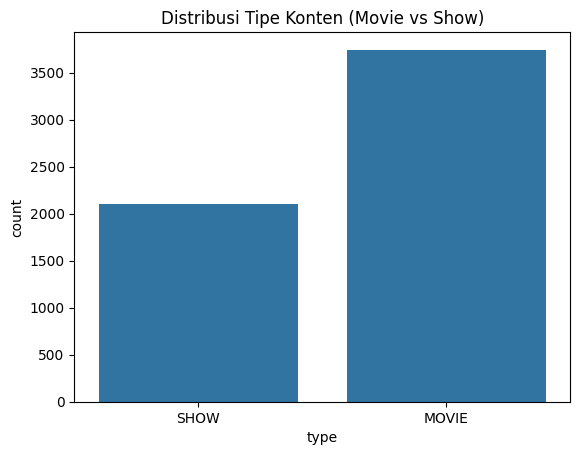

,count
type,
MOVIE,3744
SHOW,2106


In [14]:
sns.countplot(data=titles_df, x='type')
plt.title("Distribusi Tipe Konten (Movie vs Show)")
plt.show()

titles_df['type'].value_counts()

Mayoritas konten yang tersedia merupakan film (MOVIE) sebanyak 3744 judul, sedangkan acara (SHOW) berjumlah 2106. Ini menunjukkan bahwa platform lebih fokus pada penyediaan film dibandingkan serial.

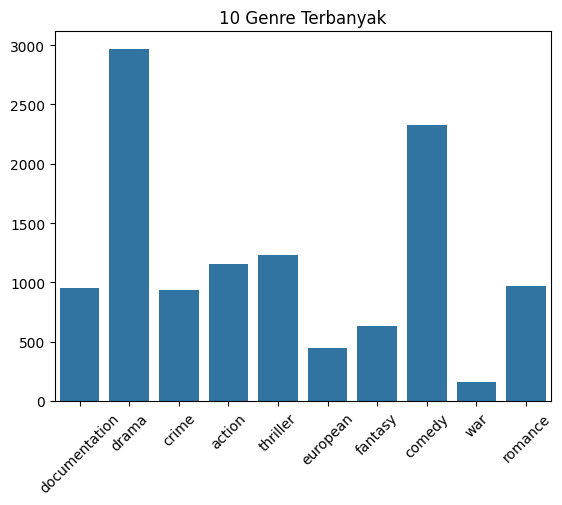

[('drama', 2968),
 ('comedy', 2325),
 ('thriller', 1228),
 ('action', 1157),
 ('romance', 971),
 ('documentation', 952),
 ('crime', 936),
 ('animation', 705),
 ('family', 682),
 ('fantasy', 630)]

In [15]:
genre_list = titles_df['genres'].dropna().apply(ast.literal_eval)
flat_genres = [genre for sublist in genre_list for genre in sublist]
genre_counts = Counter(flat_genres)

sns.barplot(x=list(genre_counts.keys())[:10], y=list(genre_counts.values())[:10])
plt.title("10 Genre Terbanyak")
plt.xticks(rotation=45)
plt.show()

genre_counts.most_common(10)

Genre terbanyak dalam dataset ini adalah drama dan comedy, masing-masing dengan lebih dari 2000 judul. Genre seperti thriller, action, dan romance juga cukup dominan, menunjukkan keberagaman selera penonton.

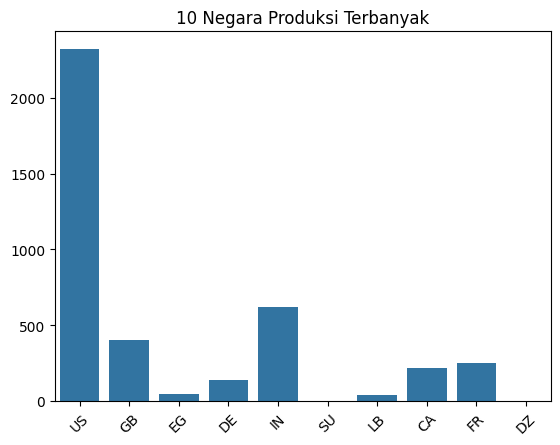

[('US', 2323),
 ('IN', 622),
 ('GB', 404),
 ('JP', 287),
 ('FR', 248),
 ('KR', 228),
 ('CA', 219),
 ('ES', 211),
 ('DE', 139),
 ('MX', 126)]

In [16]:
country_list = titles_df['production_countries'].dropna().apply(ast.literal_eval)
flat_countries = [country for sublist in country_list for country in sublist]
country_counts = Counter(flat_countries)

sns.barplot(x=list(country_counts.keys())[:10], y=list(country_counts.values())[:10])
plt.title("10 Negara Produksi Terbanyak")
plt.xticks(rotation=45)
plt.show()

country_counts.most_common(10)

Konten paling banyak berasal dari Amerika Serikat (US), disusul oleh India (IN), Inggris (GB), dan Jepang (JP). Ini menunjukkan dominasi produksi konten dari negara-negara dengan industri hiburan besar.

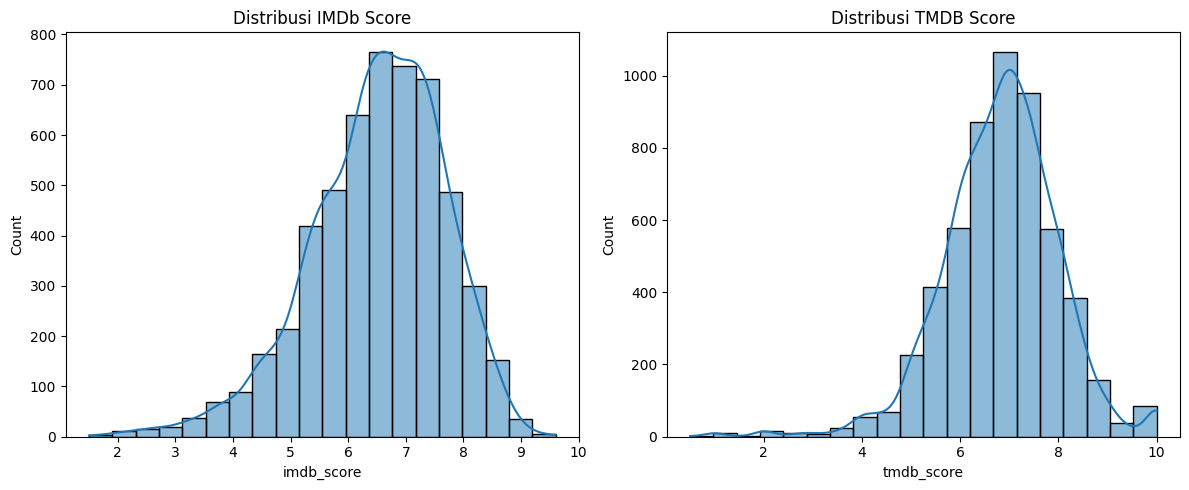

,imdb_score,tmdb_score
count,5368.000000,5539.000000
mean,6.510861,6.829175
std,1.163826,1.170391
min,1.500000,0.500000
25%,5.800000,6.100000
50%,6.600000,6.900000
75%,7.300000,7.537500
max,9.600000,10.000000


In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(titles_df['imdb_score'], bins=20, kde=True, ax=ax[0])
ax[0].set_title("Distribusi IMDb Score")

sns.histplot(titles_df['tmdb_score'], bins=20, kde=True, ax=ax[1])
ax[1].set_title("Distribusi TMDB Score")

plt.tight_layout()
plt.show()

titles_df[['imdb_score', 'tmdb_score']].describe()

Skor IMDb dan TMDb berkisar antara 1.5–10 dengan nilai rata-rata sekitar 6.5–6.8, yang mengindikasikan bahwa sebagian besar film berada dalam kualitas sedang hingga baik menurut penilaian pengguna.



In [18]:
credits_df.head()

,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


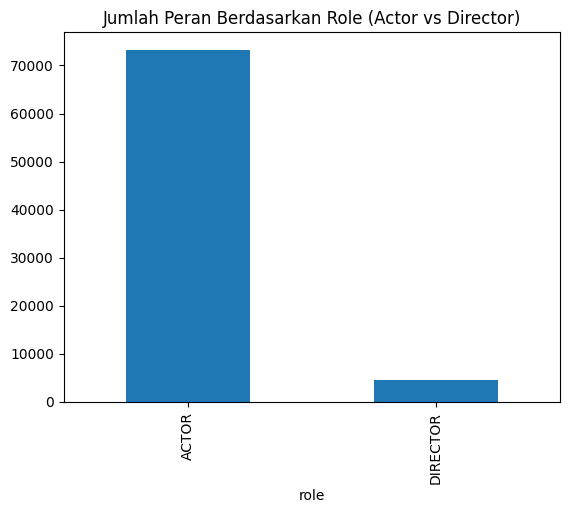

In [19]:
credits_df['role'].value_counts().plot(kind='bar')
plt.title('Jumlah Peran Berdasarkan Role (Actor vs Director)')
plt.show()

In [20]:
top_actors = credits_df[credits_df['role'] == 'ACTOR']['name'].value_counts().head(10)
top_directors = credits_df[credits_df['role'] == 'DIRECTOR']['name'].value_counts().head(10)

print("Top 10 Aktor:")
print(top_actors)

print("\nTop 10 Sutradara:")
print(top_directors)

Top 10 Aktor:
name
Boman Irani              25
Kareena Kapoor Khan      25
Shah Rukh Khan           23
Takahiro Sakurai         21
Paresh Rawal             20
Priyanka Chopra Jonas    20
Amitabh Bachchan         20
Anupam Kher              19
Yuki Kaji                19
Nawazuddin Siddiqui      19
Name: count, dtype: int64

Top 10 Sutradara:
name
Raúl Campos            20
Jan Suter              19
Ryan Polito            17
Jay Karas              15
Marcus Raboy           14
Jay Chapman            12
Cathy Garcia-Molina    12
Youssef Chahine        11
Anurag Kashyap          8
Suhas Kadav             8
Name: count, dtype: int64


Boman Irani dan Kareena Kapoor Khan menjadi aktor paling sering tampil dengan masing-masing 25 penampilan, menunjukkan dominasi aktor dari industri film India dalam dataset ini.

Raúl Campos dan Jan Suter adalah sutradara yang paling produktif dalam dataset ini, masing-masing menyutradarai lebih dari 15 konten. Ini bisa menunjukkan preferensi platform terhadap karya mereka atau konsistensi mereka dalam memproduksi konten.

# Data Preperation

In [21]:
# Cek dan hapus duplikat di titles_df
print("Duplikat di titles_df:", titles_df.duplicated().sum())
titles_df.drop_duplicates(inplace=True)

# Cek dan hapus duplikat di credits_df
print("Duplikat di credits_df:", credits_df.duplicated().sum())
credits_df.drop_duplicates(inplace=True)

Duplikat di titles_df: 0
Duplikat di credits_df: 0


- Insight: Tidak ditemukan duplikat.
- Alasan langkah: Mengecek duplikat penting untuk memastikan tidak ada entri ganda yang bisa mengganggu proses analisis dan model training. Meski tidak ada, ini langkah preventif yang wajib dalam EDA.

In [22]:
print("Missing values di titles_df:")
print(titles_df.isnull().sum())

print("\nMissing values di credits_df:")
print(credits_df.isnull().sum())

Missing values di titles_df:
id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

Missing values di credits_df:
person_id       0
id              0
name            0
character    9772
role            0
dtype: int64


In [23]:
# Untuk titles_df
titles_df['age_certification'].fillna("Unknown", inplace=True)
titles_df['imdb_score'].fillna(titles_df['imdb_score'].mean(), inplace=True)
titles_df['tmdb_score'].fillna(titles_df['tmdb_score'].mean(), inplace=True)
titles_df['seasons'].fillna(0, inplace=True)
titles_df['genres'].fillna("[]", inplace=True)
titles_df['description'].fillna("", inplace=True)

# Untuk credits_df
credits_df['character'].fillna("Unknown", inplace=True)

<ipython-input-23-6f57733754e9>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titles_df['age_certification'].fillna("Unknown", inplace=True)
<ipython-input-23-6f57733754e9>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

- Insight: Banyak nilai hilang terutama di kolom age_certification, imdb_score, tmdb_score, dan description.
- Alasan langkah:

  - Unknown untuk kolom kategorikal menjaga struktur data tanpa membuang baris.

  - Rata-rata digunakan untuk mengisi skor agar distribusi data tidak berubah drastis.

  - description, genres, dan seasons diisi default agar tidak error saat diproses string.


In [24]:
# Gabung aktor
actors = credits_df[credits_df['role'] == 'ACTOR'].groupby('id')['name'].apply(lambda x: ' '.join(x)).reset_index()
actors.columns = ['id', 'actors']

# Gabung sutradara
directors = credits_df[credits_df['role'] == 'DIRECTOR'].groupby('id')['name'].apply(lambda x: ' '.join(x)).reset_index()
directors.columns = ['id', 'directors']

# Merge ke titles_df
titles_df = titles_df.merge(actors, on='id', how='left')
titles_df = titles_df.merge(directors, on='id', how='left')

# Isi NaN hasil gabungan
titles_df['actors'].fillna("", inplace=True)
titles_df['directors'].fillna("", inplace=True)

<ipython-input-24-30495bfe4fe6>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titles_df['actors'].fillna("", inplace=True)
<ipython-input-24-30495bfe4fe6>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

- Insight: Setiap film bisa punya lebih dari satu aktor dan sutradara.
- Alasan langkah: Digabung per id agar bisa digunakan sebagai fitur teks dalam model Content-Based Filtering. Tanpa penggabungan ini, informasi penting bisa tersebar dan sulit dianalisis.
---
- Insight: Ada beberapa film yang tidak memiliki data aktor/sutradara.
- Alasan langkah: Digabungkan untuk memperkaya informasi konten tiap film. Mengisi NaN dengan string kosong mencegah error saat melakukan vektorisasi teks.

In [25]:
import ast

def combine_features(row):
    genres = " ".join(ast.literal_eval(row['genres'])) if row['genres'] != "[]" else ""
    return f"{row['title']} {row['description']} {genres} {row['age_certification']} {row['actors']} {row['directors']}"

titles_df['content'] = titles_df.apply(combine_features, axis=1)

- Insight: Fitur teks gabungan berisi informasi komprehensif tiap film.
- Alasan langkah: Ini inti dari pendekatan Content-Based Filtering. Dengan menggabungkan title, description, genres, age_certification, actors, dan directors, kita membangun deskripsi yang representatif agar sistem bisa menghitung kemiripan antar konten secara lebih akurat.

# Modelling

## Content based filtering

Content-Based Filtering adalah pendekatan sistem rekomendasi yang menyarankan film berdasarkan kemiripan konten, dalam hal ini genre dari film. Menggunakan teknik TF-IDF (Term Frequency-Inverse Document Frequency), sistem mengekstrak fitur penting dari kolom genre dan mengubahnya menjadi vektor numerik. Lalu, dengan menghitung cosine similarity antara film yang ditonton pengguna dan film lainnya, sistem dapat merekomendasikan film yang mirip secara konten. Metode ini sangat berguna saat tidak ada data interaksi antar pengguna, dan cocok untuk pengguna baru karena hanya bergantung pada preferensi kontennya sendiri.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(titles_df['content'])

# Cosine Similarity antar judul
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Index mapping berdasarkan title
indices = pd.Series(titles_df.index, index=titles_df['title']).drop_duplicates()

Langkah ini bertujuan untuk membangun sistem **Content-Based Filtering**. Dengan menggunakan `TfidfVectorizer`, kita mengubah teks pada kolom `content` menjadi representasi numerik berbasis frekuensi kata, lalu menghitung kemiripan antar film menggunakan **cosine similarity**. Hasilnya adalah matriks yang menunjukkan seberapa mirip satu film dengan yang lain berdasarkan kontennya, sehingga sistem bisa merekomendasikan film serupa.

In [27]:
# Fungsi rekomendasi
def recommend_content_based(title, n=5):
    idx = indices.get(title)
    if idx is None:
        return f"Judul '{title}' tidak ditemukan dalam dataset."

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # skip yang 0 (judul itu sendiri)
    movie_indices = [i[0] for i in sim_scores]

    return titles_df[['title', 'type', 'release_year']].iloc[movie_indices]

Fungsi ini digunakan untuk **memberikan rekomendasi film** berbasis konten. Saat pengguna memasukkan judul film, sistem akan:

1. Mencari indeks film tersebut dalam dataset.
2. Mengambil skor kemiripan (cosine similarity) dengan semua film lainnya.
3. Mengurutkan berdasarkan skor tertinggi dan **mengabaikan film itu sendiri**.
4. Mengembalikan daftar top-`n` film paling mirip berdasarkan konten seperti deskripsi, genre, aktor, dll.

Pendekatan ini memungkinkan rekomendasi yang tetap relevan bahkan tanpa interaksi pengguna lainnya.

In [28]:
recommend_content_based("Narcos", n=5)

,title,type,release_year
556,El cartel 2 - La guerra total,SHOW,2010
1805,Narcos: Mexico,SHOW,2018
3928,Tijuana,SHOW,2019
2225,Apaches,SHOW,2018
417,El Escamoso,SHOW,2001


Content-Based Filtering (TF-IDF + Cosine Similarity)

- Kelebihan:
  - Sederhana dan cepat: Menggunakan TF-IDF dan Cosine Similarity membuat perhitungannya efisien, bahkan untuk dataset menengah.

  - Interpretable: Sistem rekomendasi mudah dijelaskan karena hanya mencari kemiripan berdasarkan fitur konten (genre, deskripsi, dsb).

  - Tidak butuh data user lain: Cocok kalau user masih sedikit atau belum ada interaksi.

- Kekurangan:
  - Over-specialization: Rekomendasi cenderung terbatas pada film yang mirip, kurang eksploratif (kurang diverse).

  - Tidak bisa tangani cold start item: Film baru tanpa deskripsi yang cukup sulit untuk direkomendasikan secara akurat.

  - Tidak mempertimbangkan preferensi komunitas: Tidak tahu kalau film yang kurang mirip secara konten, tapi banyak disukai orang dengan selera mirip user.



## Collaborative Filtering

Solusi Collaborative Filtering ini menggunakan pendekatan Neural Collaborative Filtering (NCF), di mana model neural network belajar dari interaksi antara pengguna (aktor/sutradara) dan film yang pernah mereka bintangi atau sutradarai. Karena tidak tersedia rating asli, sistem menggunakan dummy rating (nilai 1) untuk menyimulasikan interaksi positif. Model kemudian dilatih untuk memprediksi kemungkinan “kesukaan” terhadap film lain, dan merekomendasikan berdasarkan skor tertinggi. Solusi ini memungkinkan rekomendasi yang lebih personal, karena memperhitungkan pola kesamaan perilaku antar pengguna yang tidak terlihat secara eksplisit dalam konten film.


#### Re-prep data untuk Collaborative Filtering

In [55]:
titles_df = pd.read_csv('/content/dataset/titles.csv')
credits_df = pd.read_csv('/content/dataset/credits.csv')

Kita perlu load ulang datanya

In [56]:
from sklearn.preprocessing import LabelEncoder

# Encode user (name → user_id)
user_encoder = LabelEncoder()
credits_df['user_id'] = user_encoder.fit_transform(credits_df['name'])
user2user_encoded = dict(zip(credits_df['name'], credits_df['user_id']))
user_encoded2user = dict(zip(credits_df['user_id'], credits_df['name']))

# Encode item (movie ID → item_id)
item_encoder = LabelEncoder()
credits_df['item_id'] = item_encoder.fit_transform(credits_df['id'])
item2item_encoded = dict(zip(credits_df['id'], credits_df['item_id']))
item_encoded2item = dict(zip(credits_df['item_id'], credits_df['id']))

# Mapping nama aktor/sutradara jadi user_id
credits_df['user_id'] = user_encoder.fit_transform(credits_df['name'])

# Mapping ID film jadi item_id
credits_df['item_id'] = item_encoder.fit_transform(credits_df['id'])

# Tambahkan dummy rating
credits_df['rating'] = 1

1. **Encode nama pengguna (aktor/sutradara) menjadi user_id**  
   Menggunakan `LabelEncoder` untuk mengubah nama menjadi angka unik, karena model machine learning hanya bisa bekerja dengan data numerik.

2. **Encode ID film menjadi item_id**  
   Sama seperti di atas, ID film diubah menjadi angka agar bisa diproses oleh model.

3. **Buat mapping dictionary (user ↔ user_id, item ↔ item_id)**  
   Mapping ini mempermudah konversi antara nama dan ID saat membuat rekomendasi.

4. **Tambahkan rating dummy (bernilai 1)**  
   Karena tidak tersedia data rating asli, kita mensimulasikan bahwa seorang aktor/sutradara “menyukai” film yang mereka terlibat di dalamnya. Ini memungkinkan kita membuat model collaborative filtering berbasis interaksi yang ada.

In [33]:
X = credits_df[['user_id', 'item_id']].values
y = credits_df['rating'].values

Langkah ini menyiapkan data untuk pelatihan model, di mana `X` berisi pasangan user dan item, dan `y` adalah dummy rating sebagai target prediksi.

In [34]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Split data menjadi 80/20

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)

        self.item_embedding = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.item_bias = layers.Embedding(num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])

        dot_product = tf.reduce_sum(user_vector * item_vector, axis=1, keepdims=True)
        x = dot_product + user_bias + item_bias
        return tf.nn.sigmoid(x)



Kelas `RecommenderNet` ini membangun model collaborative filtering berbasis neural network. Model menggunakan embedding layer untuk merepresentasikan user dan item dalam vektor berdimensi rendah. Output prediksi adalah hasil perkalian dot product antara vektor user dan item, ditambah bias masing-masing, dan dilalui fungsi aktivasi sigmoid untuk menghasilkan skor antara 0 dan 1.

In [42]:
num_users = credits_df['user_id'].nunique()
num_items = credits_df['item_id'].nunique()

model = RecommenderNet(num_users, num_items, embedding_size=50)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Langkah ini menginisialisasi dan meng-compile model `RecommenderNet`. Jumlah user dan item ditentukan dari data unik. Model di-compile dengan loss function `BinaryCrossentropy` karena rating bersifat biner (dummy = 1), dan metrik evaluasinya menggunakan `RootMeanSquaredError (RMSE)` untuk menilai seberapa baik prediksi model terhadap data aktual.

In [43]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val)
)

Epoch 1/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6716 - root_mean_squared_error: 0.4889 - val_loss: 0.6002 - val_root_mean_squared_error: 0.4508
Epoch 2/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.5515 - root_mean_squared_error: 0.4230 - val_loss: 0.5111 - val_root_mean_squared_error: 0.3975
Epoch 3/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.3845 - root_mean_squared_error: 0.3182 - val_loss: 0.4452 - val_root_mean_squared_error: 0.3514
Epoch 4/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 0.2397 - root_mean_squared_error: 0.2116 - val_loss: 0.4055 - val_root_mean_squared_error: 0.3177
Epoch 5/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1615 - root_mean_squared_error: 0.1397 - val_loss: 0.3782 - val_root_mean_squared_error: 0.2919
Epoch 6/10
1945/1945 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1278 - root_mean_squared_error: 0.0992 - val_loss: 0.3507 - val_root_mean_squared_error: 0.2682
Epoch 7/10
1945/1945 ━━━━━━━━━━━━━━━━━━

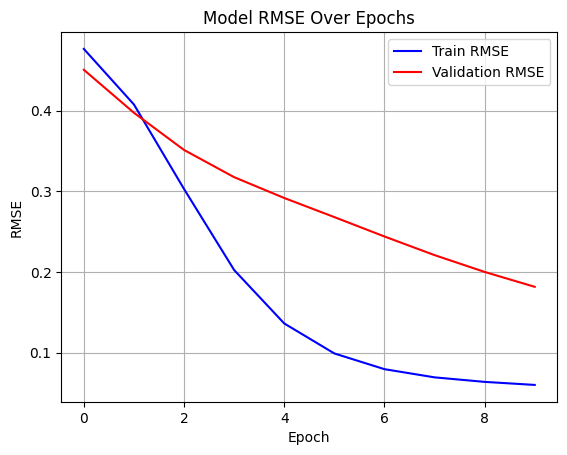

In [44]:
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE', color='blue')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', color='red')
plt.title('Model RMSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()


Insight: Model tidak menunjukkan tanda-tanda overfitting karena gap antara train dan validation RMSE tetap relatif kecil dan keduanya menurun seiring waktu. Ini mengindikasikan bahwa model belajar dengan baik tanpa kehilangan performa di data baru.

In [53]:
def recommend_collaborative(user_name, n=10):
    # Cek user
    if user_name not in user2user_encoded:
        return f"User '{user_name}' tidak ditemukan."

    # Encode user
    user_id = user2user_encoded[user_name]

    # Buat daftar semua item_id
    all_item_ids = credits_df['item_id'].unique()

    # Ambil semua item yang belum pernah ditonton user
    items_watched_by_user = credits_df[credits_df['user_id'] == user_id]['item_id'].tolist()
    items_not_watched = np.setdiff1d(all_item_ids, items_watched_by_user)

    # Buat input untuk prediksi
    user_input = np.array([[user_id, item_id] for item_id in items_not_watched])

    # Prediksi skor dari model
    predicted_ratings = model.predict(user_input).flatten()

    # Ambil top-N rekomendasi
    top_indices = predicted_ratings.argsort()[-n:][::-1]
    top_item_ids = items_not_watched[top_indices]

    # Ambil judul film dari item_id
    recommended_titles = titles_df[titles_df['id'].isin([item_encoded2item[item] for item in top_item_ids])]

    return recommended_titles[['title', 'type', 'release_year']].reset_index(drop=True)

Fungsi recommend_collaborative() memberikan rekomendasi film untuk seorang user berdasarkan pendekatan collaborative filtering. Fungsi ini memprediksi skor kesukaan untuk semua film yang belum ditonton user, menggunakan model neural network. Lalu, sistem menampilkan N film dengan prediksi skor tertinggi sebagai rekomendasi yang dipersonalisasi.

In [54]:
recommend_collaborative("Robert De Niro", n=5)

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


,title,type,release_year
0,The Departed,MOVIE,2006
1,The Fighter,MOVIE,2010
2,Les Misérables,MOVIE,2012
3,Rolling Thunder Revue: A Bob Dylan Story by Ma...,MOVIE,2019
4,"tick, tick... BOOM!",MOVIE,2021


Collaborative Filtering (Neural Collaborative Filtering dengan TensorFlow)
- Kelebihan:
  - Menangkap pola kompleks antar user dan item melalui embedding.

  - Rekomendasi personalized: Bisa menyarankan film yang sangat berbeda kontennya, tapi sering disukai oleh user yang mirip.

  - Model non-linear: Neural network menangkap relasi yang tidak bisa ditangkap metode klasik (misalnya dot product saja).

- Kekurangan:
  - Butuh banyak interaksi: Performanya sangat tergantung dari jumlah data user-item (di kasus ini pakai dummy rating).

  - Cold-start problem: User/item baru yang belum punya cukup interaksi akan sulit direkomendasikan.

  - Komputasi lebih berat: Dibandingkan dengan cosine similarity, proses training NCF butuh waktu dan resource lebih besar.

# Evaluation

**Evaluation & Business Understanding Integration**

---

### 1. Evaluation for Content-Based Filtering (CBF)

**Metric Used:** Cosine Similarity

**Explanation:**
Cosine Similarity mengukur sejauh mana dua vektor (dalam hal ini representasi TF-IDF dari film) serupa satu sama lain dengan menghitung nilai cosinus dari sudut di antara keduanya.

**Formula:**
( A · B) / (||A|| * ||B||)

**Interpretasi:**
Nilai cosine similarity berkisar dari 0 hingga 1, di mana 1 berarti dua item sangat mirip. Dalam konteks ini, semakin tinggi nilai similarity antar film, semakin besar kemungkinan film tersebut relevan untuk direkomendasikan.

**Business Connection:**
- CBF menjawab kebutuhan pengguna untuk menemukan film yang mirip dengan yang sudah disukai sebelumnya.
- Dengan memberikan rekomendasi berdasarkan genre dan deskripsi yang mirip, pengguna akan merasa sistem "mengerti selera mereka", meningkatkan retensi dan keterlibatan.

---

### 2. Evaluation for Collaborative Filtering (CF)

**Metric Used:** Root Mean Squared Error (RMSE)

**Explanation:**
RMSE mengukur perbedaan antara prediksi model dengan data aktual. Semakin kecil RMSE, semakin akurat prediksi model.

**Formula:**
√((1/n) * Σ(yi - ŷi)²)

**Interpretasi:**
Nilai RMSE yang rendah menunjukkan bahwa model berhasil memperkirakan preferensi pengguna dengan baik.

**Business Connection:**
- RMSE digunakan untuk mengevaluasi apakah rekomendasi model mendekati kenyataan (meski berbasis dummy rating).
- CF mampu merekomendasikan film yang mungkin tidak terpikirkan oleh pengguna tapi disukai oleh user serupa, membuka potensi penemuan film baru.

---

### 3. Relevance to Business Understanding

**Problem Statements:**
1. CBF menjawab kebutuhan untuk merekomendasikan film berdasarkan preferensi konten masa lalu.
2. CF menjawab tantangan dalam menemukan film baru melalui perilaku pengguna lain yang mirip.

**Goals:**
- CBF memberikan personalisasi berdasarkan konten.
- CF memperluas rekomendasi ke film yang mungkin tidak memiliki konten serupa namun relevan berdasarkan pola pengguna lain.

**Solution Approaches:**
- Kombinasi dua pendekatan ini memberikan sistem yang lebih menyeluruh: CBF cocok untuk pengguna baru (cold start) dan CF baik untuk pengguna aktif.
- Metrik evaluasi digunakan untuk memastikan bahwa model tidak hanya bekerja secara matematis, tapi juga memberikan nilai bisnis dengan meningkatkan user engagement dan kemungkinan eksplorasi konten.

---

### Final Notes
- Evaluasi dilakukan dengan metrik yang sesuai untuk masing-masing pendekatan.
- Setiap metrik memiliki interpretasi yang berhubungan langsung dengan kualitas pengalaman pengguna.
- Kombinasi CBF dan CF membentuk sistem rekomendasi yang kuat, scalable, dan adaptif terhadap berbagai kebutuhan pengguna Netflix.